In [1]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from yahoo_fin.stock_info import get_data
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import re
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
news_tables = {}
url = 'https://finviz.com/quote.ashx?t='    # FInviz to extract data
tickers = [
    "GS", "INFY", "ABT", "NKE", "CVX", "MMM", "WMT", "T", "RIO", "AMT", "AEP"   # change the ticker accordingly
]

for tick in tickers:
  final_url = url + tick

  req = Request(url = final_url, headers = {'user-agent':'my-app'})
  response = urlopen(req)

  html = BeautifulSoup(response, 'html')       # to parse into html

  # Extracting the Finviz's news into dictionary
  table = html.find(id='news-table')
  news_tables[tick] = table

In [3]:
# Obtaining the sectors of the stock
sector=[]

for tick in tickers:
    final_url = url + tick

    req = Request(url=final_url, headers={'user-agent': 'my-app'})
    response = urlopen(req)

    html = BeautifulSoup(response, 'html.parser')
    anchor_elements = html.findAll('a')

    text = str(anchor_elements[21])
    pattern = r'>(.*?)<'
    result = re.search(pattern, text)
    
    value = result.group(1)
    sector.append([tick, value])
    
sector

[['GS', 'Financial'],
 ['INFY', 'Technology'],
 ['ABT', 'Healthcare'],
 ['NKE', 'Consumer Cyclical'],
 ['CVX', 'Energy'],
 ['MMM', 'Industrials'],
 ['WMT', 'Consumer Defensive'],
 ['T', 'Communication Services'],
 ['RIO', 'Basic Materials'],
 ['AMT', 'Real Estate'],
 ['AEP', 'Utilities']]

In [4]:
# Cleaning the data from dictionary and storing into nested list

cleaned_data = []

for ticker, news_table in news_tables.items():

  for row in news_table.findAll('tr'):
    if row.a and row.td:
        title = row.a.get_text()                 # news is inside anchor tag

        timestamp = row.td.text.split(' ')       # timestamp inside td tag
        if timestamp[13] == '':
          time = timestamp[12].strip()
        else:
          date = timestamp[12]
          time = timestamp[13].strip()

        cleaned_data.append([ticker, date, time, title])
  else:
        pass

cleaned_data


[['GS',
  'Today',
  '01:21PM',
  'Hedge Fund and Insider Trading News: David Tepper, Ray Dalio, RA Capital Management, Millennium Management, Biohaven Ltd (BHVN), EyePoint Pharmaceuticals Inc. (EYPT), and More'],
 ['GS',
  'Apr-22-24',
  '03:20PM',
  'Goldman is getting out of the robo-advisory business'],
 ['GS',
  'Apr-22-24',
  '02:33PM',
  'Final Trades: Goldman Sachs, SL Green and Taiwan Semi'],
 ['GS',
  'Apr-22-24',
  '01:38PM',
  "Goldman Sachs Selling Marcus Invest's Digital Investing Accounts to Betterment"],
 ['GS',
  'Apr-22-24',
  '12:49PM',
  "Cathie Wood's Latest Stock Portfolio: Top 10 Stock Picks"],
 ['GS',
  'Apr-22-24',
  '09:48AM',
  'PPG Industries, Inc. (NYSE:PPG) Q1 2024 Earnings Call Transcript'],
 ['GS',
  'Apr-22-24',
  '09:21AM',
  'Am rica M vil, S.A.B. de C.V. (NYSE:AMX) Q1 2024 Earnings Call Transcript'],
 ['GS',
  'Apr-22-24',
  '05:00AM',
  'AI is becoming a big deal for big banks. What the CEOs of JPMorgan, Goldman Sachs and more are saying'],
 ['GS',


In [5]:
# Convert into dataframe:

sector_dict = {ticker: s for ticker, s in sector}
df = pd.DataFrame(cleaned_data, columns = ['Ticker', 'Date', 'Time', 'Title'])
df['Sector'] = df['Ticker'].map(sector_dict)
df['Sector'] = df['Sector'].replace({'Real Estate': 'Housing', 'Basic Materials': 'Materials', 
                                         'Communication Services': 'Telecommunication',
                                         'Consumer Cyclical': 'Goods', 'Consumer Defensive':'Services' })
df.head(10)

,Ticker,Date,Time,Title,Sector
0,GS,Today,01:21PM,Hedge Fund and Insider Trading News: David Tep...,Financial
1,GS,Apr-22-24,03:20PM,Goldman is getting out of the robo-advisory bu...,Financial
2,GS,Apr-22-24,02:33PM,"Final Trades: Goldman Sachs, SL Green and Taiw...",Financial
3,GS,Apr-22-24,01:38PM,Goldman Sachs Selling Marcus Invest's Digital ...,Financial
4,GS,Apr-22-24,12:49PM,Cathie Wood's Latest Stock Portfolio: Top 10 S...,Financial
5,GS,Apr-22-24,09:48AM,"PPG Industries, Inc. (NYSE:PPG) Q1 2024 Earnin...",Financial
6,GS,Apr-22-24,09:21AM,"Am rica M vil, S.A.B. de C.V. (NYSE:AMX) Q1 20...",Financial
7,GS,Apr-22-24,05:00AM,AI is becoming a big deal for big banks. What ...,Financial
8,GS,Apr-22-24,04:39AM,Buyout Firm CVC Sets Price Range for 1.6 Billi...,Financial
9,GS,Apr-22-24,12:00AM,"Move Aside, Big Banks: Giant Funds Now Rule Wa...",Financial


## Classifying the news, into 15 classes

In [6]:
import tensorflow as tf

In [7]:
model = tf.keras.models.load_model('news.keras')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 512)            │       1,312,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,638,511 (32.95 MB)

 Trainable params: 2,879,503 (10.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,759,008 (21.97 MB)

In [8]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]

    # Lemmatization 
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['processed_Title'] = df['Title'].apply(preprocess_text)
y_train = ['GLOBAL', 'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS',
       'ENVIRONMENT', 'CRIME', 'SCIENCE', 'BUSINESS', 'GLAMOUR',
       'CONSUMABLES', 'MEDIA', 'LIFESTYLE', 'TRAVEL', 'MONEY']

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rushi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rushi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rushi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
df['processed_Title']

0       hedge fund insider trading news david tepper r...
1                                goldman getting business
2          final trade goldman sachs sl green taiwan semi
3       goldman sachs selling marcus invest digital in...
4       cathie wood latest stock portfolio top stock pick
                              ...                        
1095                         market update aep fl hon rtx
1096    aep energy partner seek solar wind project pjm...
1097    pso file proposal increase power supply stabil...
1098    aep focus capital investment regulated busines...
1099               aep name kelly chief financial officer
Name: processed_Title, Length: 1100, dtype: object

In [10]:
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

max_len = 100  # Same as used during training
texts = df['processed_Title']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(df['processed_Title'])
X_pad = pad_sequences(sequences, maxlen=max_len)

#'y_train' contains the training labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

# Predict categories
predicted_labels = model.predict(X_pad)
predicted_categories = label_encoder.inverse_transform(np.argmax(predicted_labels, axis=1))

# Add predicted categories to the DataFrame
df['predicted_category'] = predicted_categories
df.drop('processed_Title', axis=1, inplace=True)
df

35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 370ms/step


,Ticker,Date,Time,Title,Sector,predicted_category
0,GS,Today,01:21PM,Hedge Fund and Insider Trading News: David Tep...,Financial,POLITICS
1,GS,Apr-22-24,03:20PM,Goldman is getting out of the robo-advisory bu...,Financial,CONSUMABLES
2,GS,Apr-22-24,02:33PM,"Final Trades: Goldman Sachs, SL Green and Taiw...",Financial,POLITICS
3,GS,Apr-22-24,01:38PM,Goldman Sachs Selling Marcus Invest's Digital ...,Financial,POLITICS
4,GS,Apr-22-24,12:49PM,Cathie Wood's Latest Stock Portfolio: Top 10 S...,Financial,POLITICS
...,...,...,...,...,...,...
1095,AEP,Dec-23-22,01:43PM,"Market Update: AEP, FL, HON, RTX",Utilities,ENVIRONMENT
1096,AEP,Dec-16-22,01:46PM,AEP ENERGY PARTNERS SEEKS SOLAR AND WIND PROJE...,Utilities,GLAMOUR
1097,AEP,Nov-17-22,10:45AM,PSO Files Proposal to Increase Power Supply an...,Utilities,BUSINESS
1098,AEP,Nov-11-22,04:30PM,AEP TO FOCUS CAPITAL INVESTMENTS ON REGULATED ...,Utilities,CONSUMABLES


In [11]:
df['predicted_category'].unique()

array(['POLITICS', 'CONSUMABLES', 'SCIENCE', 'LIFESTYLE', 'SPORTS',
       'ENTERTAINMENT', 'GLOBAL', 'GLAMOUR', 'TRAVEL', 'MEDIA', 'MONEY',
       'TECH', 'BUSINESS', 'CRIME', 'ENVIRONMENT'], dtype=object)

## Loading the correlation matirx

In [12]:
df_corr = pd.read_pickle("Correlation.pkl")
df_corr

,Financial,Technology,Healthcare,Energy,Goods,Industrials,Telecommunication,Utilities,Housing,Materials,Services
GLOBAL,0.556262,0.471298,0.321607,0.442350,0.277357,0.088483,0.288500,0.165269,0.241510,0.213168,0.355875
TECH,0.242386,0.646456,0.211720,0.244999,0.235420,0.203843,0.246383,0.157450,0.179294,0.290506,0.246874
SPORTS,0.247516,0.265751,0.160846,0.143096,0.177717,-0.035063,0.120852,0.181334,0.137295,0.086629,0.261364
ENTERTAINMENT,0.294437,0.324226,0.271564,0.203356,0.179933,0.071282,0.111270,0.181909,0.137450,0.173131,0.313253
POLITICS,0.280176,0.267151,0.139289,0.219497,0.081301,-0.043438,0.005455,0.032017,0.111242,0.090786,0.126490
ENVIRONMENT,0.329549,0.414100,0.253186,0.414791,0.194752,-0.006207,0.184310,0.253870,0.329063,0.317795,0.305592
CRIME,0.262297,0.164024,0.084457,0.127412,0.156061,-0.062135,-0.003409,0.033151,0.202097,0.129954,0.212277
SCIENCE,0.201467,0.605558,0.262105,0.284591,0.095879,0.003840,0.182522,0.058906,0.144391,0.355212,0.244201
BUSINESS,0.579179,0.512937,0.320753,0.314592,0.408734,0.031621,0.235113,0.257977,0.314143,0.288887,0.504475
GLAMOUR,0.022079,0.080638,-0.044467,0.010029,0.016565,0.033712,-0.080381,-0.040045,-0.039512,0.026994,-0.006250


In [13]:
def get_score(row):
    sector = row['Sector']
    category = row['predicted_category']
    score = df_corr.loc[category, sector]
    return score

# Append a new column 'Score' to df based on correlation values
df['Score'] = df.apply(get_score, axis=1)
df

,Ticker,Date,Time,Title,Sector,predicted_category,Score
0,GS,Today,01:21PM,Hedge Fund and Insider Trading News: David Tep...,Financial,POLITICS,0.280176
1,GS,Apr-22-24,03:20PM,Goldman is getting out of the robo-advisory bu...,Financial,CONSUMABLES,-0.112156
2,GS,Apr-22-24,02:33PM,"Final Trades: Goldman Sachs, SL Green and Taiw...",Financial,POLITICS,0.280176
3,GS,Apr-22-24,01:38PM,Goldman Sachs Selling Marcus Invest's Digital ...,Financial,POLITICS,0.280176
4,GS,Apr-22-24,12:49PM,Cathie Wood's Latest Stock Portfolio: Top 10 S...,Financial,POLITICS,0.280176
...,...,...,...,...,...,...,...
1095,AEP,Dec-23-22,01:43PM,"Market Update: AEP, FL, HON, RTX",Utilities,ENVIRONMENT,0.253870
1096,AEP,Dec-16-22,01:46PM,AEP ENERGY PARTNERS SEEKS SOLAR AND WIND PROJE...,Utilities,GLAMOUR,-0.040045
1097,AEP,Nov-17-22,10:45AM,PSO Files Proposal to Increase Power Supply an...,Utilities,BUSINESS,0.257977
1098,AEP,Nov-11-22,04:30PM,AEP TO FOCUS CAPITAL INVESTMENTS ON REGULATED ...,Utilities,CONSUMABLES,0.066932


In [14]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Rushi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [15]:
# Using Sentiemnt analysis on Web scraped data

vader = SentimentIntensityAnalyzer()

f = lambda Title: vader.polarity_scores(Title)['compound']
df['sentiment'] = df['Title'].apply(f)
df['Date'] = pd.to_datetime(df['Date'], errors = 'coerce')     # conerting date string to datetime format
df['Date'] = df['Date'].fillna(pd.Timestamp.today().date())    # replacing NaT with today's date
df['compound'] = df['sentiment']*df['Score']
df.head(10)


C:\Users\Rushi\AppData\Local\Temp\ipykernel_20812\71369697.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors = 'coerce')     # conerting date string to datetime format


,Ticker,Date,Time,Title,Sector,predicted_category,Score,sentiment,compound
0,GS,2024-04-24,01:21PM,Hedge Fund and Insider Trading News: David Tep...,Financial,POLITICS,0.280176,0.0000,0.00000
1,GS,2024-04-22 00:00:00,03:20PM,Goldman is getting out of the robo-advisory bu...,Financial,CONSUMABLES,-0.112156,0.0000,-0.00000
2,GS,2024-04-22 00:00:00,02:33PM,"Final Trades: Goldman Sachs, SL Green and Taiw...",Financial,POLITICS,0.280176,0.0000,0.00000
3,GS,2024-04-22 00:00:00,01:38PM,Goldman Sachs Selling Marcus Invest's Digital ...,Financial,POLITICS,0.280176,0.0000,0.00000
4,GS,2024-04-22 00:00:00,12:49PM,Cathie Wood's Latest Stock Portfolio: Top 10 S...,Financial,POLITICS,0.280176,0.2023,0.05668
5,GS,2024-04-22 00:00:00,09:48AM,"PPG Industries, Inc. (NYSE:PPG) Q1 2024 Earnin...",Financial,POLITICS,0.280176,0.0000,0.00000
6,GS,2024-04-22 00:00:00,09:21AM,"Am rica M vil, S.A.B. de C.V. (NYSE:AMX) Q1 20...",Financial,POLITICS,0.280176,0.0000,0.00000
7,GS,2024-04-22 00:00:00,05:00AM,AI is becoming a big deal for big banks. What ...,Financial,POLITICS,0.280176,0.0000,0.00000
8,GS,2024-04-22 00:00:00,04:39AM,Buyout Firm CVC Sets Price Range for 1.6 Billi...,Financial,POLITICS,0.280176,0.0000,0.00000
9,GS,2024-04-22 00:00:00,12:00AM,"Move Aside, Big Banks: Giant Funds Now Rule Wa...",Financial,POLITICS,0.280176,0.0000,0.00000


In [16]:
# Making dataframe more presentable
df['Date'] = pd.to_datetime(df['Date'])
mean_df = df.groupby(['Ticker', pd.Grouper(key='Date', freq='D')])['compound'].mean().unstack()
mean_df


Date,2024-03-06,2024-03-07,2024-03-11,2024-03-12,2024-03-14,2024-03-15,2024-03-17,2024-03-18,2024-03-19,2024-03-20,...,2024-02-15,2024-02-17,2024-03-03,2024-03-23,2024-04-07,2024-03-30,2024-01-17,2024-01-30,2024-02-02,2024-02-11
Ticker,,,,,,,,,,,,,,,,,,,,,
ABT,0.012205,0.036682,0.030943,0.031131,0.0,0.011217,0.000000,0.000000,-0.005360,0.015786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AEP,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMT,0.085846,0.000000,0.000000,NaN,0.0,0.030213,0.196251,NaN,0.038752,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CVX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
INFY,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,0.194192,NaN,NaN,...,0.031197,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MMM,NaN,-0.002259,0.013106,0.001795,0.0,-0.000832,NaN,NaN,-0.005024,-0.003620,...,NaN,NaN,0.00000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN
NKE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.011935,NaN,NaN,NaN,NaN
RIO,0.021885,NaN,NaN,NaN,0.0,NaN,NaN,0.000000,0.000000,0.000000,...,NaN,NaN,-0.00581,NaN,0.017331,0.033500,0.082126,-0.016634,-0.049543,0.0


In [17]:
# Scaling down the sentiment using minmaxscalar

for ticker in mean_df.index:
    row = mean_df.loc[ticker]

    # Convert row to 2D array to fit MinMaxScaler
    values = row.values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(values)
    mean_df.loc[ticker] = scaled_values.flatten()

mean_df


Date,2024-03-06,2024-03-07,2024-03-11,2024-03-12,2024-03-14,2024-03-15,2024-03-17,2024-03-18,2024-03-19,2024-03-20,...,2024-02-15,2024-02-17,2024-03-03,2024-03-23,2024-04-07,2024-03-30,2024-01-17,2024-01-30,2024-02-02,2024-02-11
Ticker,,,,,,,,,,,,,,,,,,,,,
ABT,0.022103,0.283543,0.222246,0.224257,-0.108252,0.011551,-0.108252,-0.108252,-0.165500,0.060358,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AEP,NaN,NaN,-0.635421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMT,0.173306,-0.469488,-0.469488,NaN,-0.469488,-0.243257,1.000000,NaN,-0.179319,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CVX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
INFY,0.071334,NaN,0.071334,NaN,NaN,NaN,NaN,0.586333,NaN,NaN,...,0.154068,0.071334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MMM,NaN,-0.087843,0.452974,0.054824,-0.008341,-0.037618,NaN,NaN,-0.185178,-0.135751,...,NaN,NaN,-0.008341,-0.008341,-0.008341,NaN,NaN,NaN,NaN,NaN
NKE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.162716,NaN,NaN,NaN,NaN
RIO,0.360184,NaN,NaN,NaN,0.127741,NaN,NaN,0.127741,0.127741,0.127741,...,NaN,NaN,0.066029,NaN,0.311814,0.483542,1.0,-0.048931,-0.398454,0.127741


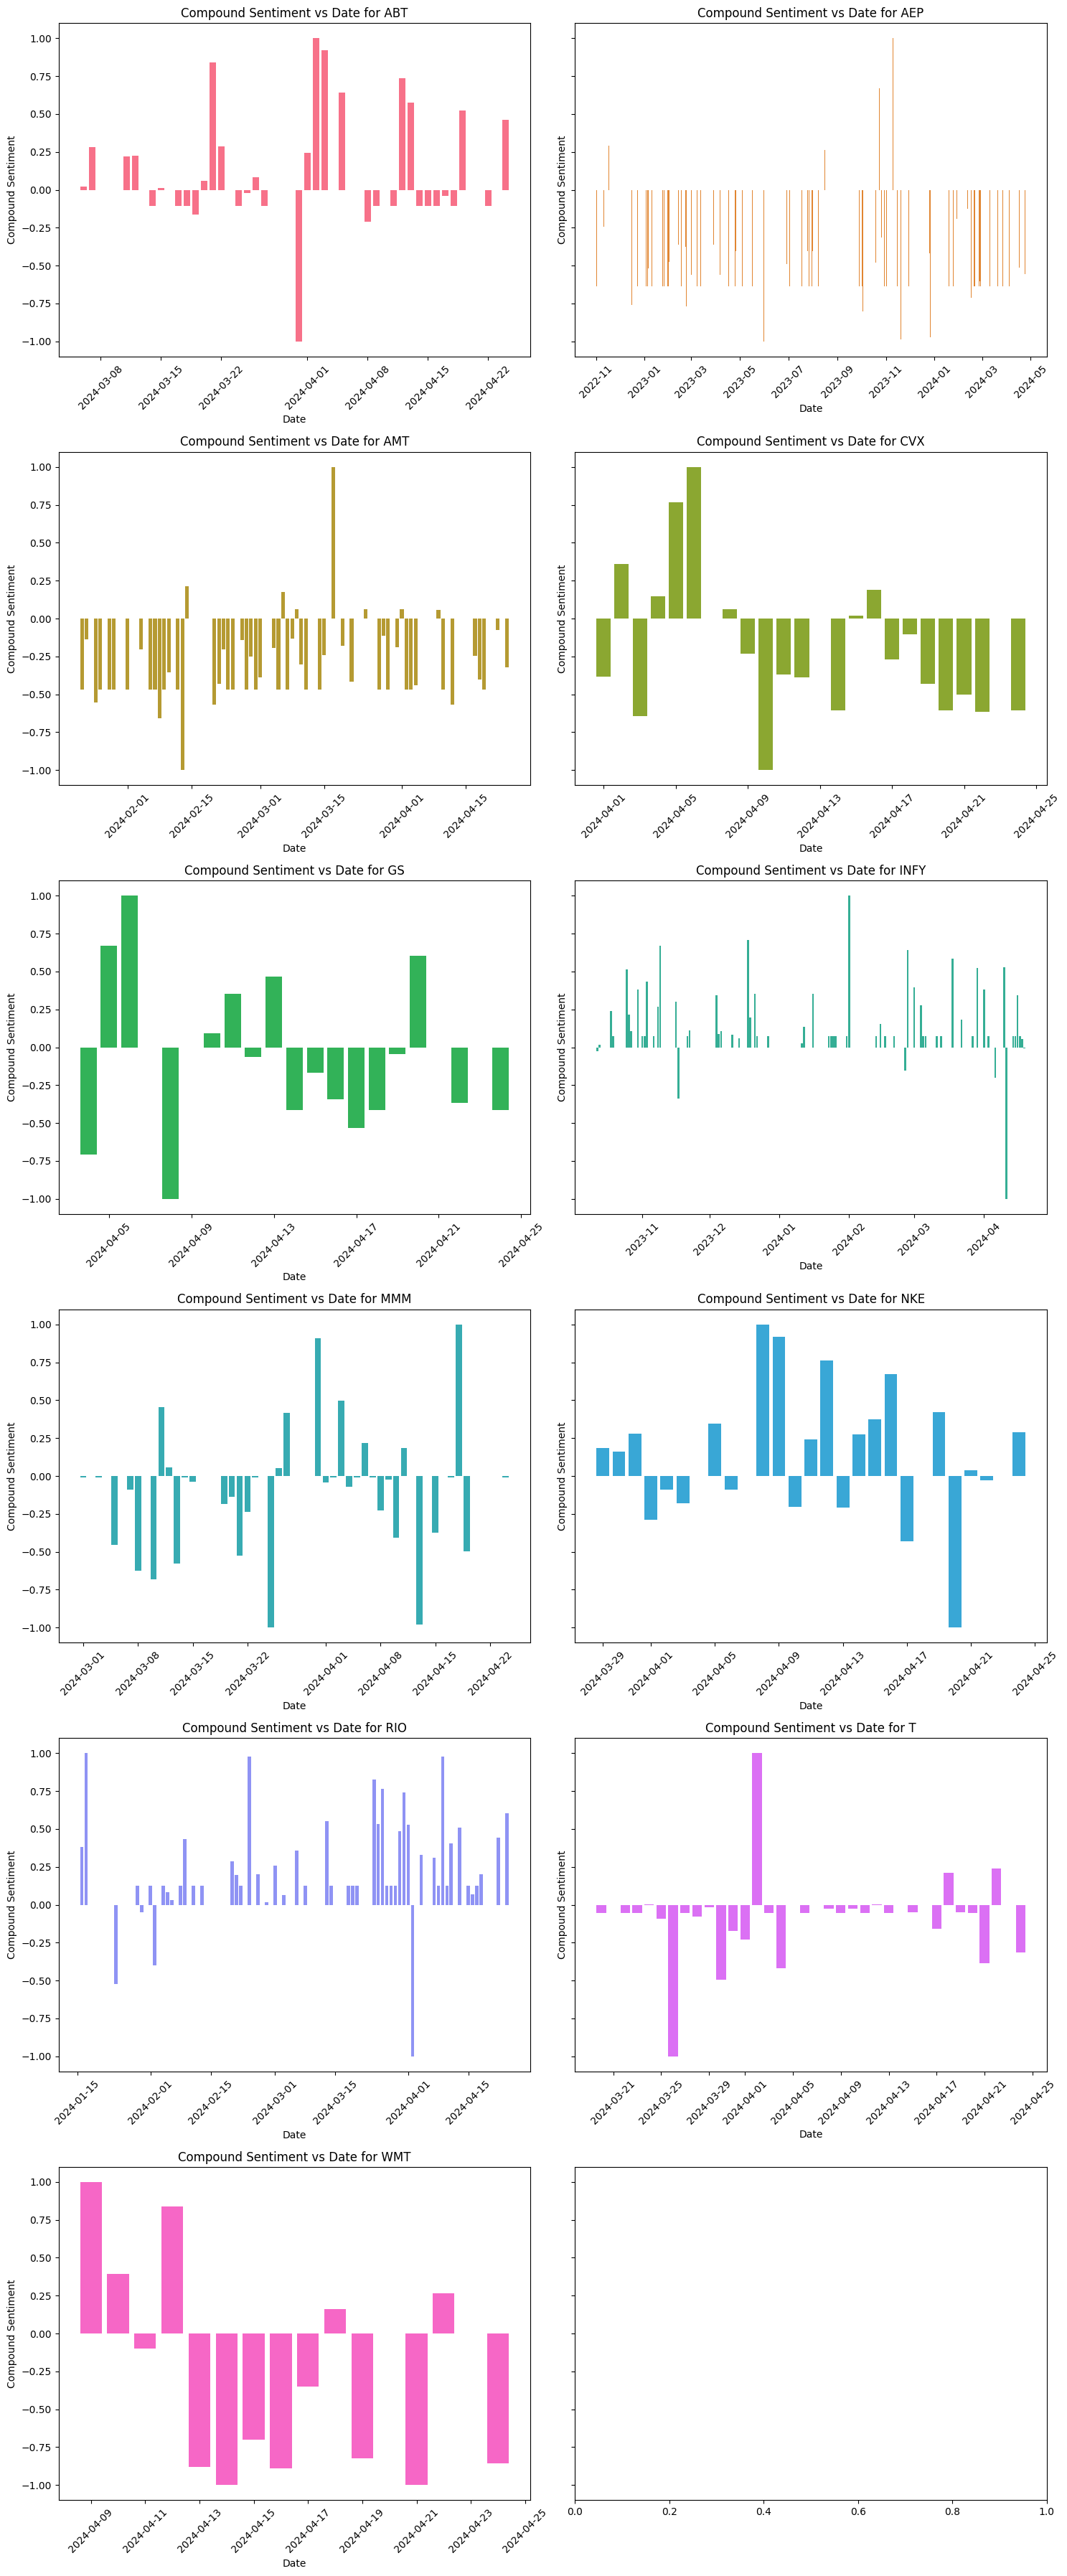

In [18]:
num_tickers = len(mean_df.index)
colors = sns.color_palette("husl", n_colors=num_tickers)
date_dict = {}

# Create subplots
fig, axes = plt.subplots((num_tickers + 1) // 2, 2, figsize=(15, 6 * ((num_tickers + 1) // 2)), sharey=True)

# Iterate over each ticker and plot a bar graph in each subplot
for i, ticker in enumerate(mean_df.index):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Exclude NaN values from the mean_df for the current ticker
    valid_dates = mean_df.columns[~mean_df.loc[ticker].isna()]
    valid_data = mean_df.loc[ticker, valid_dates]
    
    ax.bar(valid_dates, valid_data, color=colors[i])
    ax.set_xlabel('Date')
    ax.set_ylabel('Compound Sentiment')
    ax.set_title(f'Compound Sentiment vs Date for {ticker}')
    ax.tick_params(axis='x', rotation=45)

    # Add valid dates to the dictionary for the current ticker
    date_dict[ticker] = valid_dates.tolist()

# Adjust layout
plt.tight_layout()
plt.show()


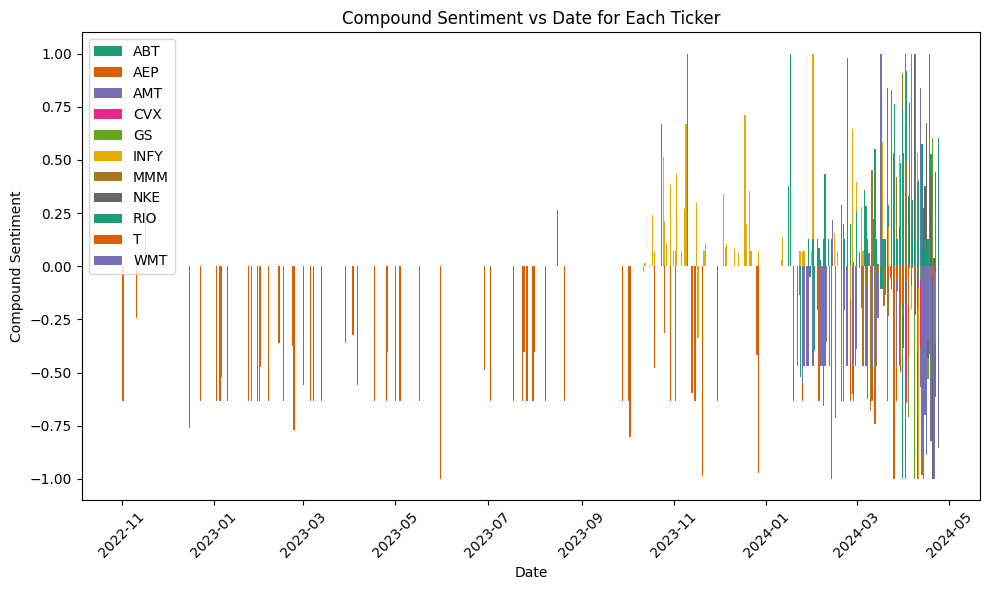

In [19]:
# Combining the plots
tickers = mean_df.index
num_tickers = len(tickers)

colors = sns.color_palette("Dark2", n_colors=num_tickers)
plt.figure(figsize=(10, 6))

for ticker, color in zip(mean_df.index, colors):
    plt.bar(mean_df.columns, mean_df.loc[ticker], color=color, label=ticker)

plt.xlabel('Date')
plt.ylabel('Compound Sentiment')
plt.title('Compound Sentiment vs Date for Each Ticker')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [20]:
# Dataframe for ticker and compound
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Ticker'] = pd.Categorical(df['Ticker'], categories=tickers, ordered=True)

# Group by 'Date' and 'Ticker' and calculate mean of 'compound'
compound_df = df.groupby(['Date', 'Ticker'])['compound'].mean().reset_index()
compound_df.dropna(inplace=True)

# Sort the DataFrame by 'Ticker' and 'Date'
compound_df = compound_df.sort_values(by=['Ticker', 'Date'])
compound_df.reset_index(drop=True, inplace=True)
compound_df

,Date,Ticker,compound
0,2024-03-06,ABT,0.012205
1,2024-03-07,ABT,0.036682
2,2024-03-11,ABT,0.030943
3,2024-03-12,ABT,0.031131
4,2024-03-14,ABT,0.000000
...,...,...,...
422,2024-04-18,WMT,0.048075
423,2024-04-19,WMT,0.007308
424,2024-04-21,WMT,0.000000
425,2024-04-22,WMT,0.052355


In [21]:
# Extracting change from yahoo finace

dfs = []
date_list = sorted(mean_df.columns.tolist())

for t in tickers:
    try:
        sign = yf.download(t, start=date_list[0], end=date_list[-1], interval='1d')

        if not sign.empty:
            sign['change'] = sign['Close'].diff()
            sign['change'] = sign['change'].fillna(0)
            sign = sign.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Close'])

            # Scale 'change' using MinMaxScaler with custom bounds (-1 to 1)
            scaler = MinMaxScaler(feature_range=(-1, 1))
            sign['change'] = scaler.fit_transform(sign[['change']])
            sign['Ticker'] = t

            # Append the scaled data to the list of DataFrames
            dfs.append(sign)
    except Exception as e:
        print(f"Failed to retrieve data for {t}: {e}")

# Concatenate DataFrames for all tickers
combined_data_all = pd.concat(dfs, axis=0)
combined_data_all.reset_index(inplace=True)
combined_data_all.rename(columns={'index': 'Date'}, inplace=True)
combined_data = combined_data_all[combined_data_all.apply(lambda row: row['Date'] in date_dict.get(row['Ticker'], []), axis=1)]
combined_data.reset_index(inplace=True)
del combined_data['index']
combined_data



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,change,Ticker
0,2024-03-06,-0.114856,ABT
1,2024-03-07,-0.004594,ABT
2,2024-03-11,-0.364471,ABT
3,2024-03-12,-0.159265,ABT
4,2024-03-14,-0.447168,ABT
...,...,...,...
348,2024-04-16,0.182098,WMT
349,2024-04-17,0.155771,WMT
350,2024-04-18,0.103115,WMT
351,2024-04-19,0.276876,WMT


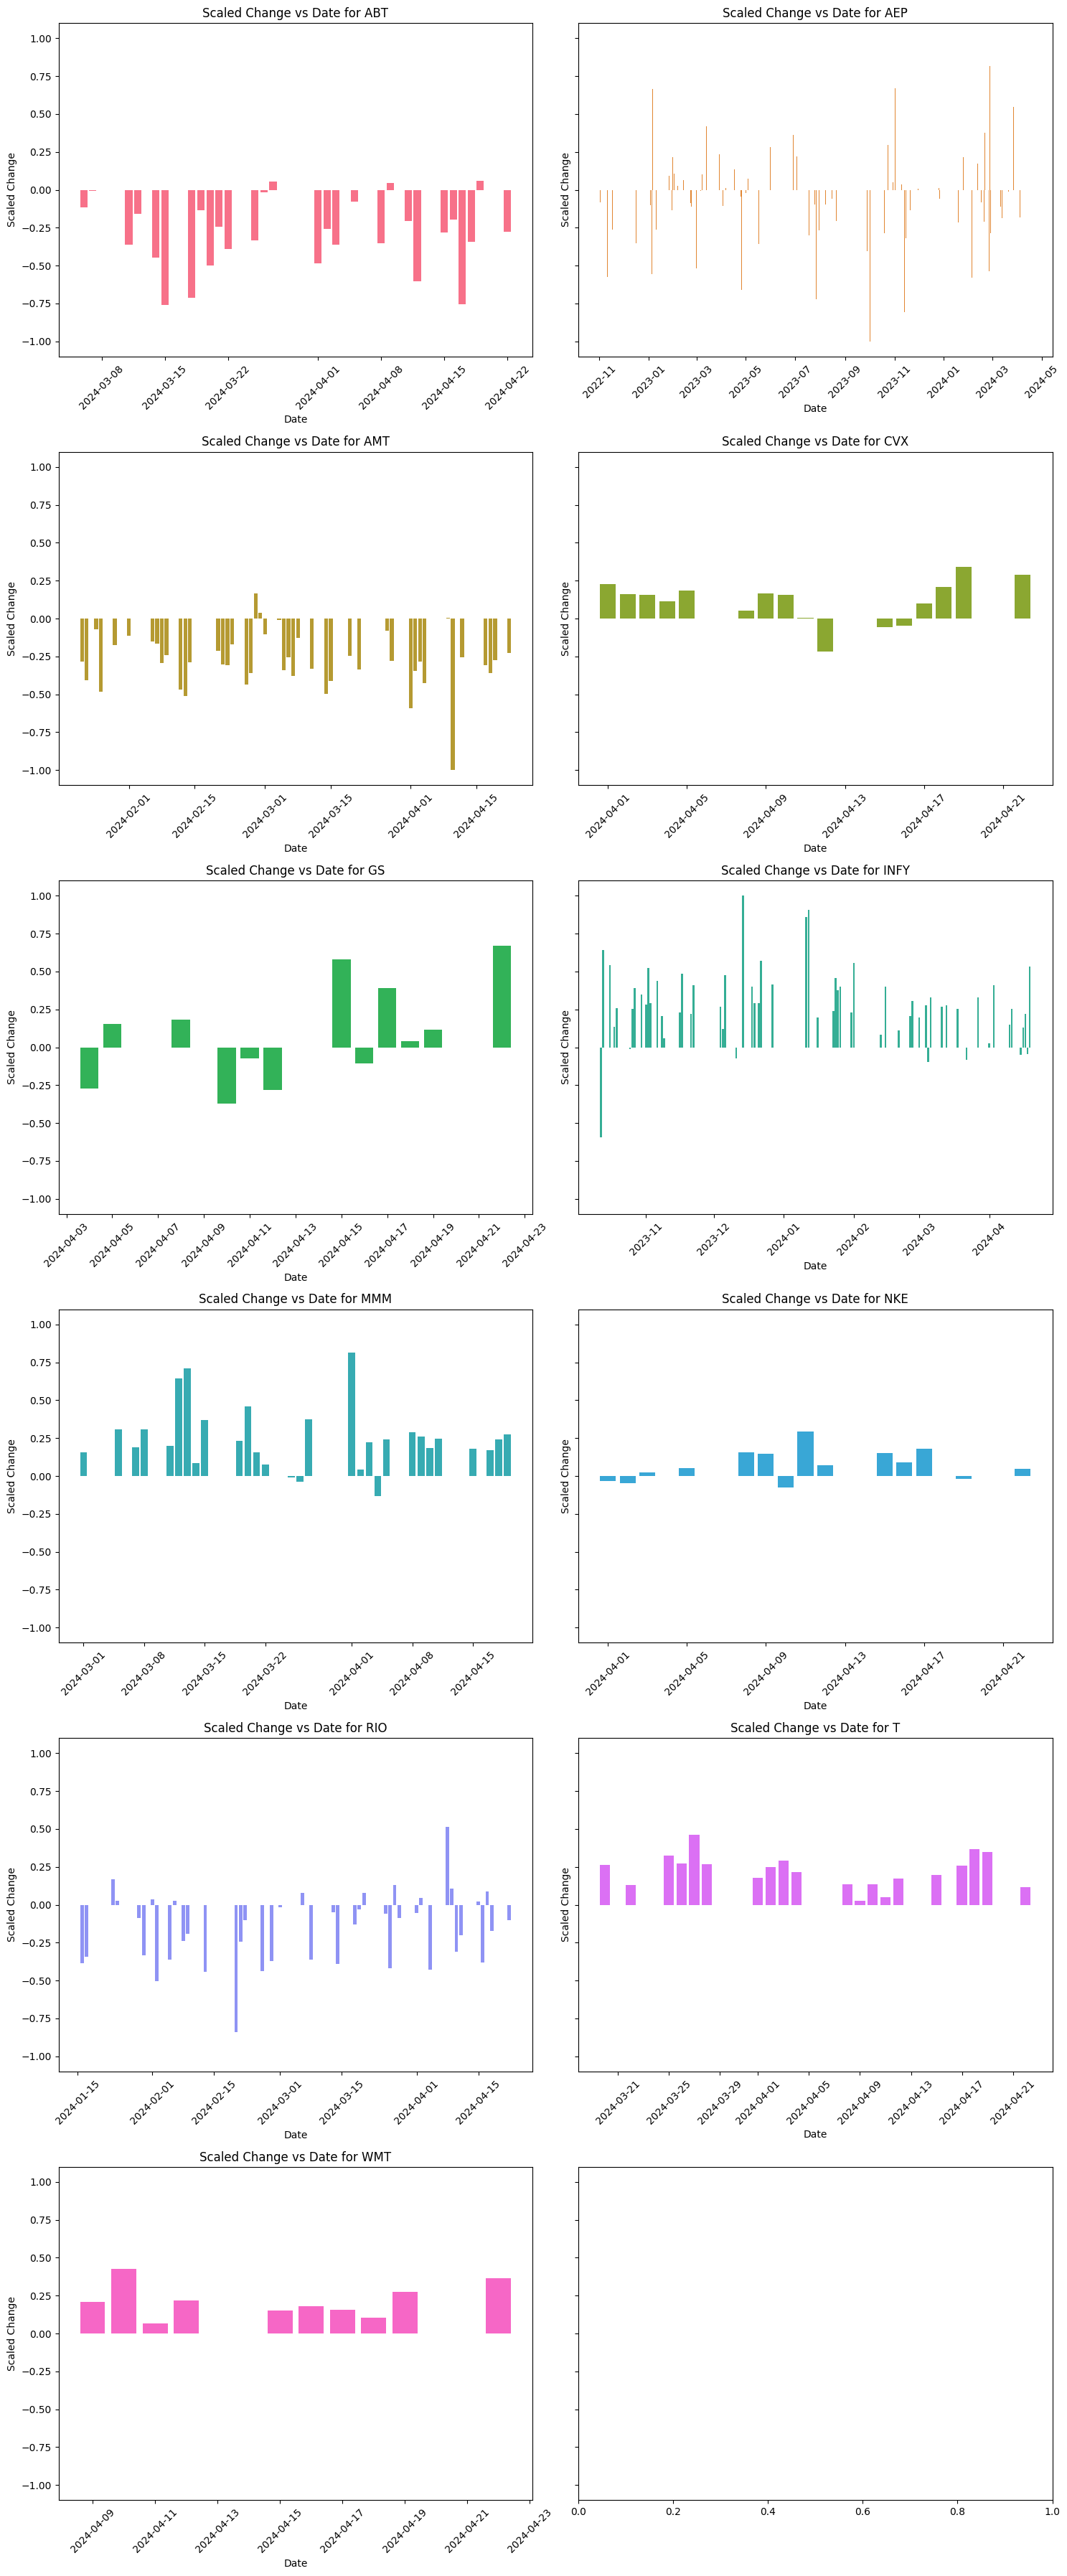

In [22]:
# Ploting the scaled change wrt ticker
num_tickers = len(combined_data['Ticker'].unique())
colors = sns.color_palette("husl", n_colors=num_tickers)

# Create subplots
fig, axes = plt.subplots((num_tickers + 1) // 2, 2, figsize=(15, 6 * ((num_tickers + 1) // 2)), sharey=True)

# Iterate over each ticker and plot a bar graph in each subplot
for i, ticker in enumerate(combined_data['Ticker'].unique()):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    data = combined_data[combined_data['Ticker'] == ticker]
    ax.bar(data['Date'], data['change'], color=colors[i])
    ax.set_xlabel('Date')
    ax.set_ylabel('Scaled Change')
    ax.set_title(f'Scaled Change vs Date for {ticker}')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

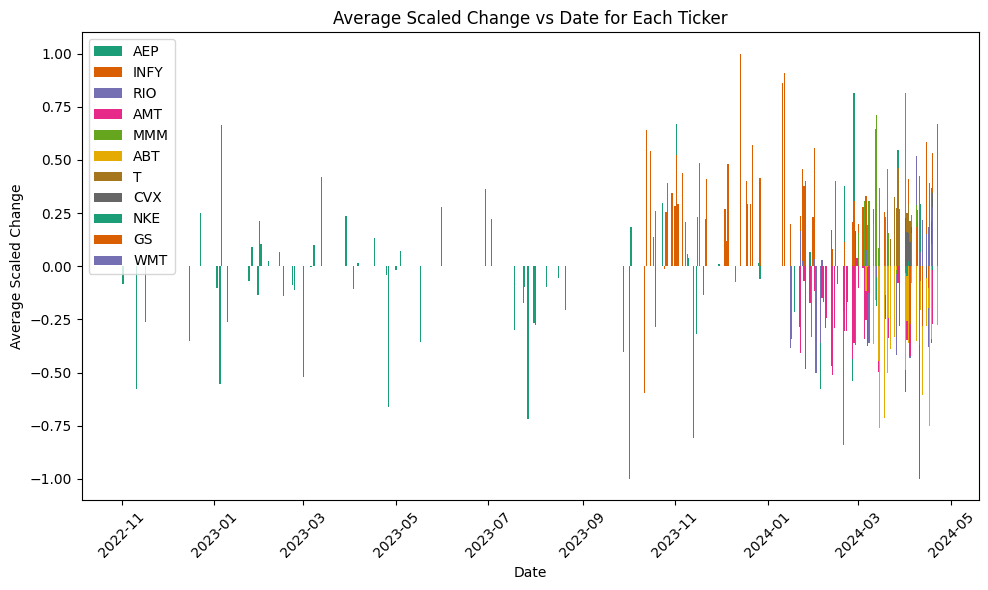

In [23]:
# Combining the change for all ticker 
aggregated_data = combined_data.groupby(['Date', 'Ticker']).mean().reset_index()

num_tickers = len(aggregated_data['Ticker'].unique())
colors = sns.color_palette("Dark2", n_colors=num_tickers)
plt.figure(figsize=(10, 6))

for ticker, color in zip(aggregated_data['Ticker'].unique(), colors):
    data = aggregated_data[aggregated_data['Ticker'] == ticker]
    plt.bar(data['Date'], data['change'], color=color, label=ticker)

plt.xlabel('Date')
plt.ylabel('Average Scaled Change')
plt.title('Average Scaled Change vs Date for Each Ticker')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [24]:
# Getting the MSE for ticker
combined_data_filtered = combined_data[combined_data['Date'].isin(compound_df['Date'])]
merged_df = pd.merge(combined_data_filtered, compound_df, on=['Date', 'Ticker'], how='inner')

# Calculate MSE for each ticker
mse_dict = {}
for ticker in tickers:
    ticker_data = merged_df[merged_df['Ticker'] == ticker]
    mse = mean_squared_error(ticker_data['change'], ticker_data['compound'])
    mse_dict[ticker] = mse

mse_data = {'Ticker': list(mse_dict.keys()), 'MSE': list(mse_dict.values())}
mse_df = pd.DataFrame(mse_data)
mse_df


,Ticker,MSE
0,ABT,0.155894
1,AEP,0.114125
2,AMT,0.123210
3,CVX,0.028243
4,GS,0.114323
5,INFY,0.138490
6,MMM,0.105777
7,NKE,0.012116
8,RIO,0.087755
9,T,0.061252


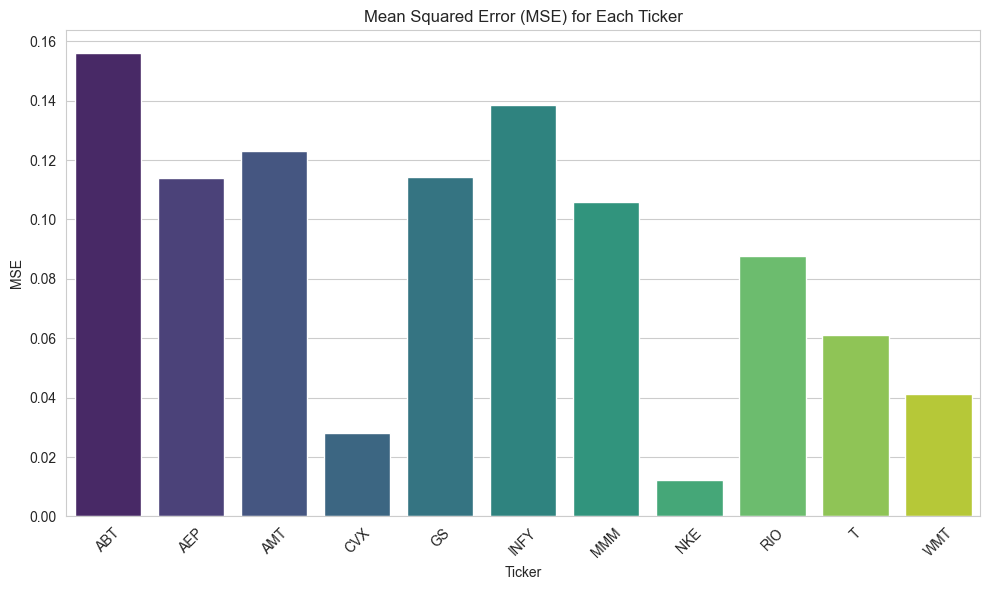

In [25]:
# Ploting the results of MSE
sns.set_style("whitegrid")

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Ticker', y='MSE', data=mse_df, palette="viridis")
plt.title('Mean Squared Error (MSE) for Each Ticker')
plt.xlabel('Ticker')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [26]:
merged_df

,Date,change,Ticker,compound
0,2024-03-06,-0.114856,ABT,0.012205
1,2024-03-07,-0.004594,ABT,0.036682
2,2024-03-11,-0.364471,ABT,0.030943
3,2024-03-12,-0.159265,ABT,0.031131
4,2024-03-14,-0.447168,ABT,0.000000
...,...,...,...,...
348,2024-04-16,0.182098,WMT,0.004554
349,2024-04-17,0.155771,WMT,0.026844
350,2024-04-18,0.103115,WMT,0.048075
351,2024-04-19,0.276876,WMT,0.007308


In [27]:
grouped_df = df.groupby(['Date', 'Ticker']).agg({'Score': 'mean', 'sentiment': 'mean'}).reset_index()

# Merge the two dataframes based on Date and Ticker
result_df = pd.merge(merged_df, grouped_df, on=['Date', 'Ticker'], how='left')
result_df = result_df.rename(columns={'Score': 'Weights', 'sentiment': 'News_sentiment', 'compound':'Predicted', 'change':'Actual'})
result_df = result_df[['Date', 'Ticker', 'Weights', 'News_sentiment', 'Predicted', 'Actual']]
result_df

,Date,Ticker,Weights,News_sentiment,Predicted,Actual
0,2024-03-06,ABT,0.158090,0.077200,0.012205,-0.114856
1,2024-03-07,ABT,0.141658,0.263350,0.036682,-0.004594
2,2024-03-11,ABT,0.152077,0.191025,0.030943,-0.364471
3,2024-03-12,ABT,0.244154,0.223500,0.031131,-0.159265
4,2024-03-14,ABT,0.139289,0.000000,0.000000,-0.447168
...,...,...,...,...,...,...
348,2024-04-16,WMT,0.195301,0.000156,0.004554,0.182098
349,2024-04-17,WMT,0.176521,0.139323,0.026844,0.155771
350,2024-04-18,WMT,0.173771,0.266125,0.048075,0.103115
351,2024-04-19,WMT,0.126490,0.057775,0.007308,0.276876


In [28]:
!pip install openpyxl

In [29]:
# Saving the file(optional), to make excel file for result_df
output = r"C:/Users/Rushi/Desktop/News_dataset/result.xlsx"  # add the path accordingly
result_df.to_excel(output , index=False)

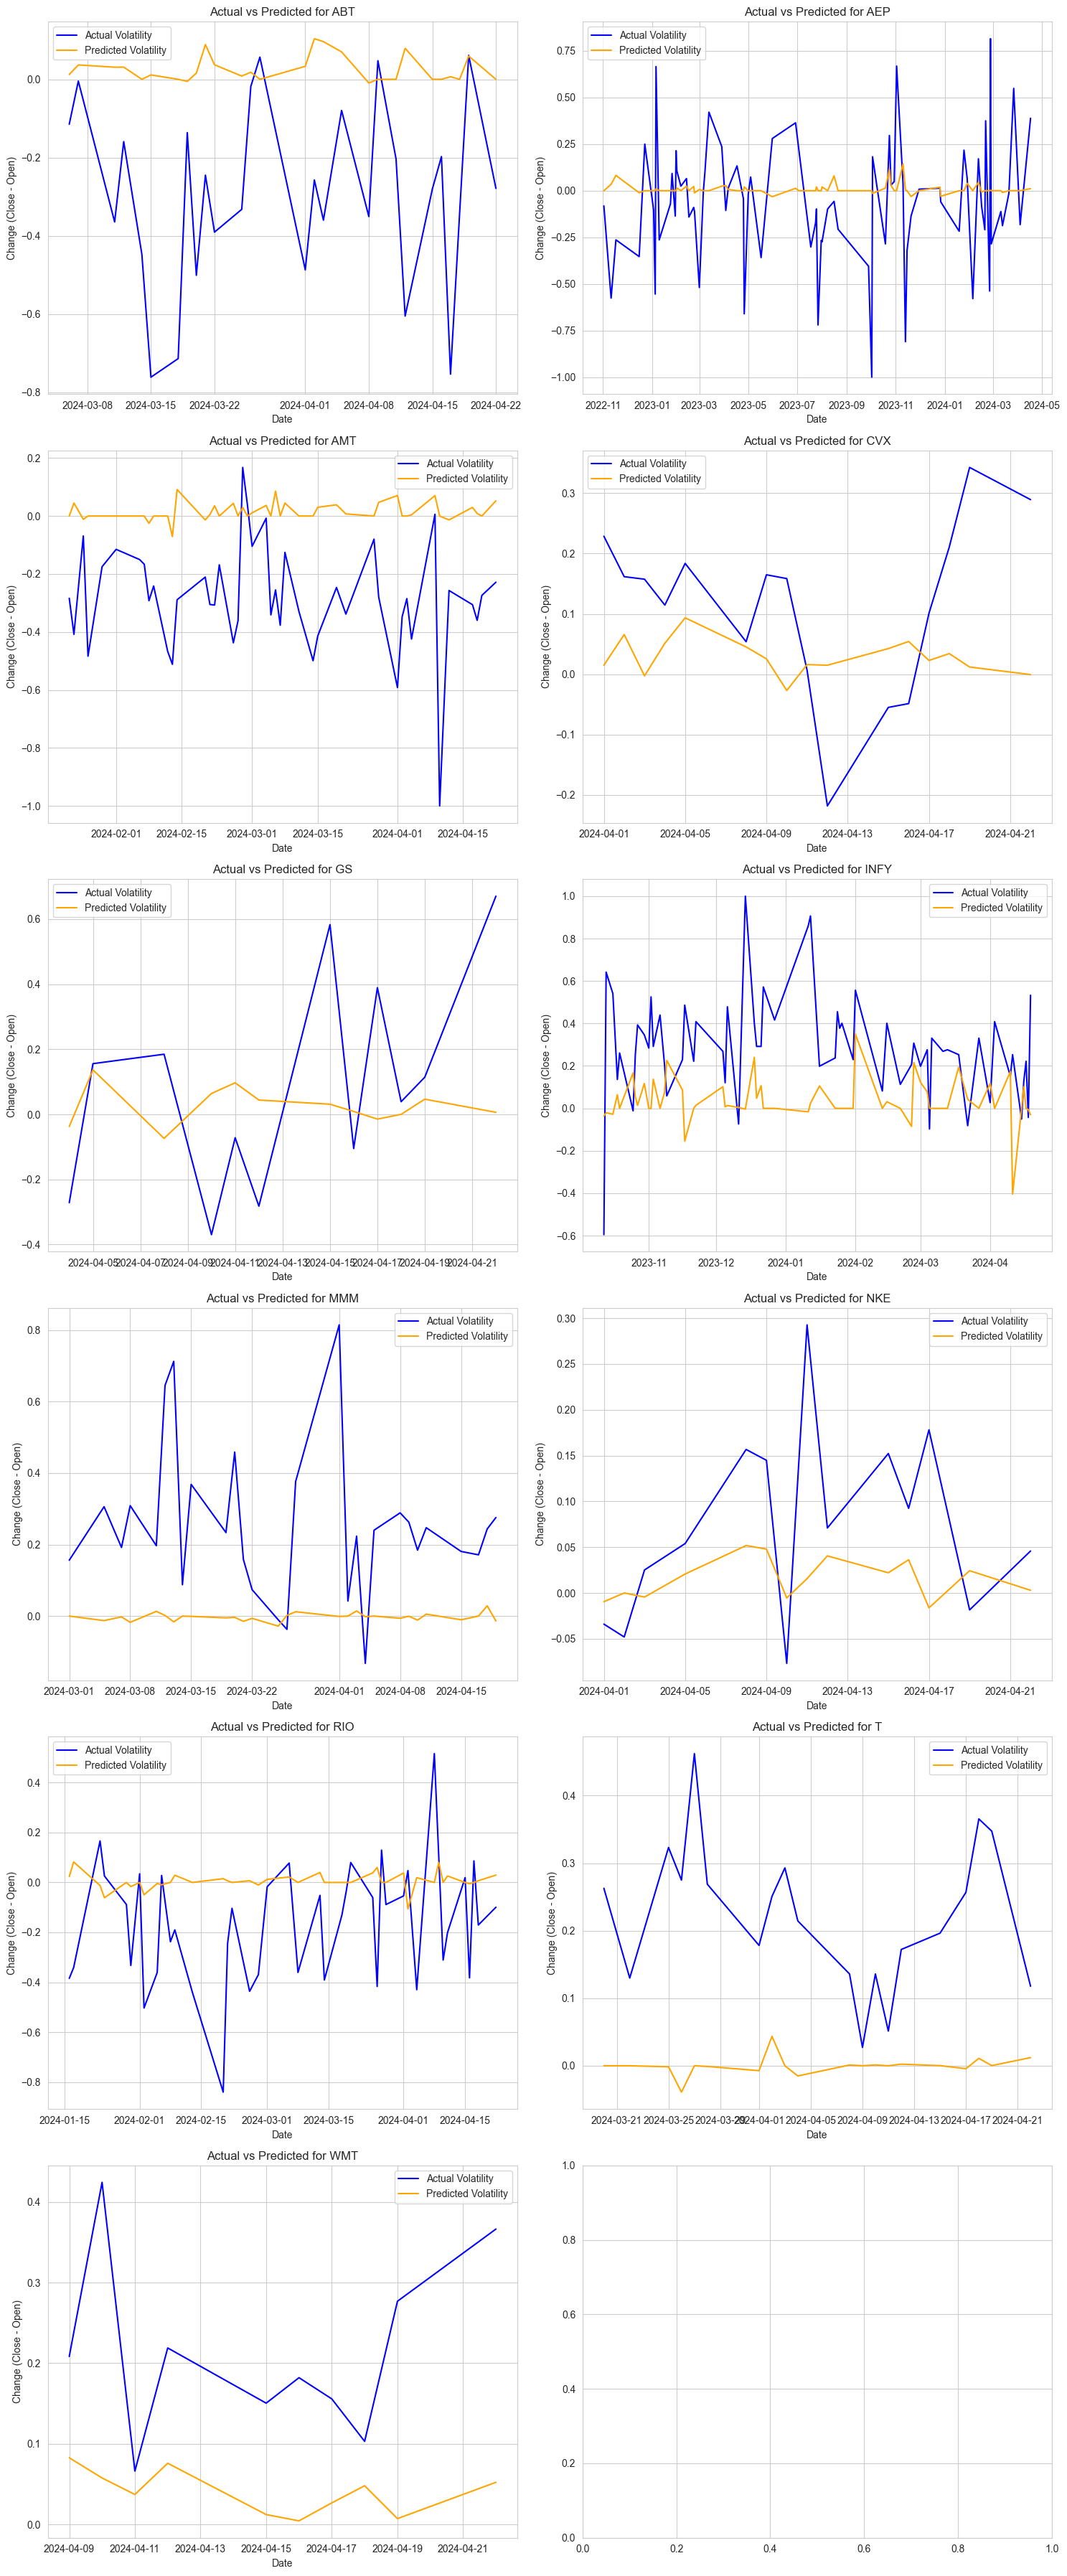

In [49]:
#Plot of the predicted and actual volatility ie change(Close-open)

tickers = result_df['Ticker'].unique()

num_rows = (len(tickers) + 1) // 2
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))
axes = axes.flatten()

# Iterate over each ticker and its corresponding subplot
for i, (ticker, ax) in enumerate(zip(tickers, axes)):
    ticker_data = result_df[result_df['Ticker'] == ticker]
    
    ax.plot(ticker_data['Date'], ticker_data['Actual'], label='Actual Volatility', color='blue')
    ax.plot(ticker_data['Date'], ticker_data['Predicted'], label='Predicted Volatility', color='orange')
    ax.set_title(f'Actual vs Predicted for {ticker}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Change (Close - Open)')
    ax.legend()

plt.tight_layout()
plt.show()


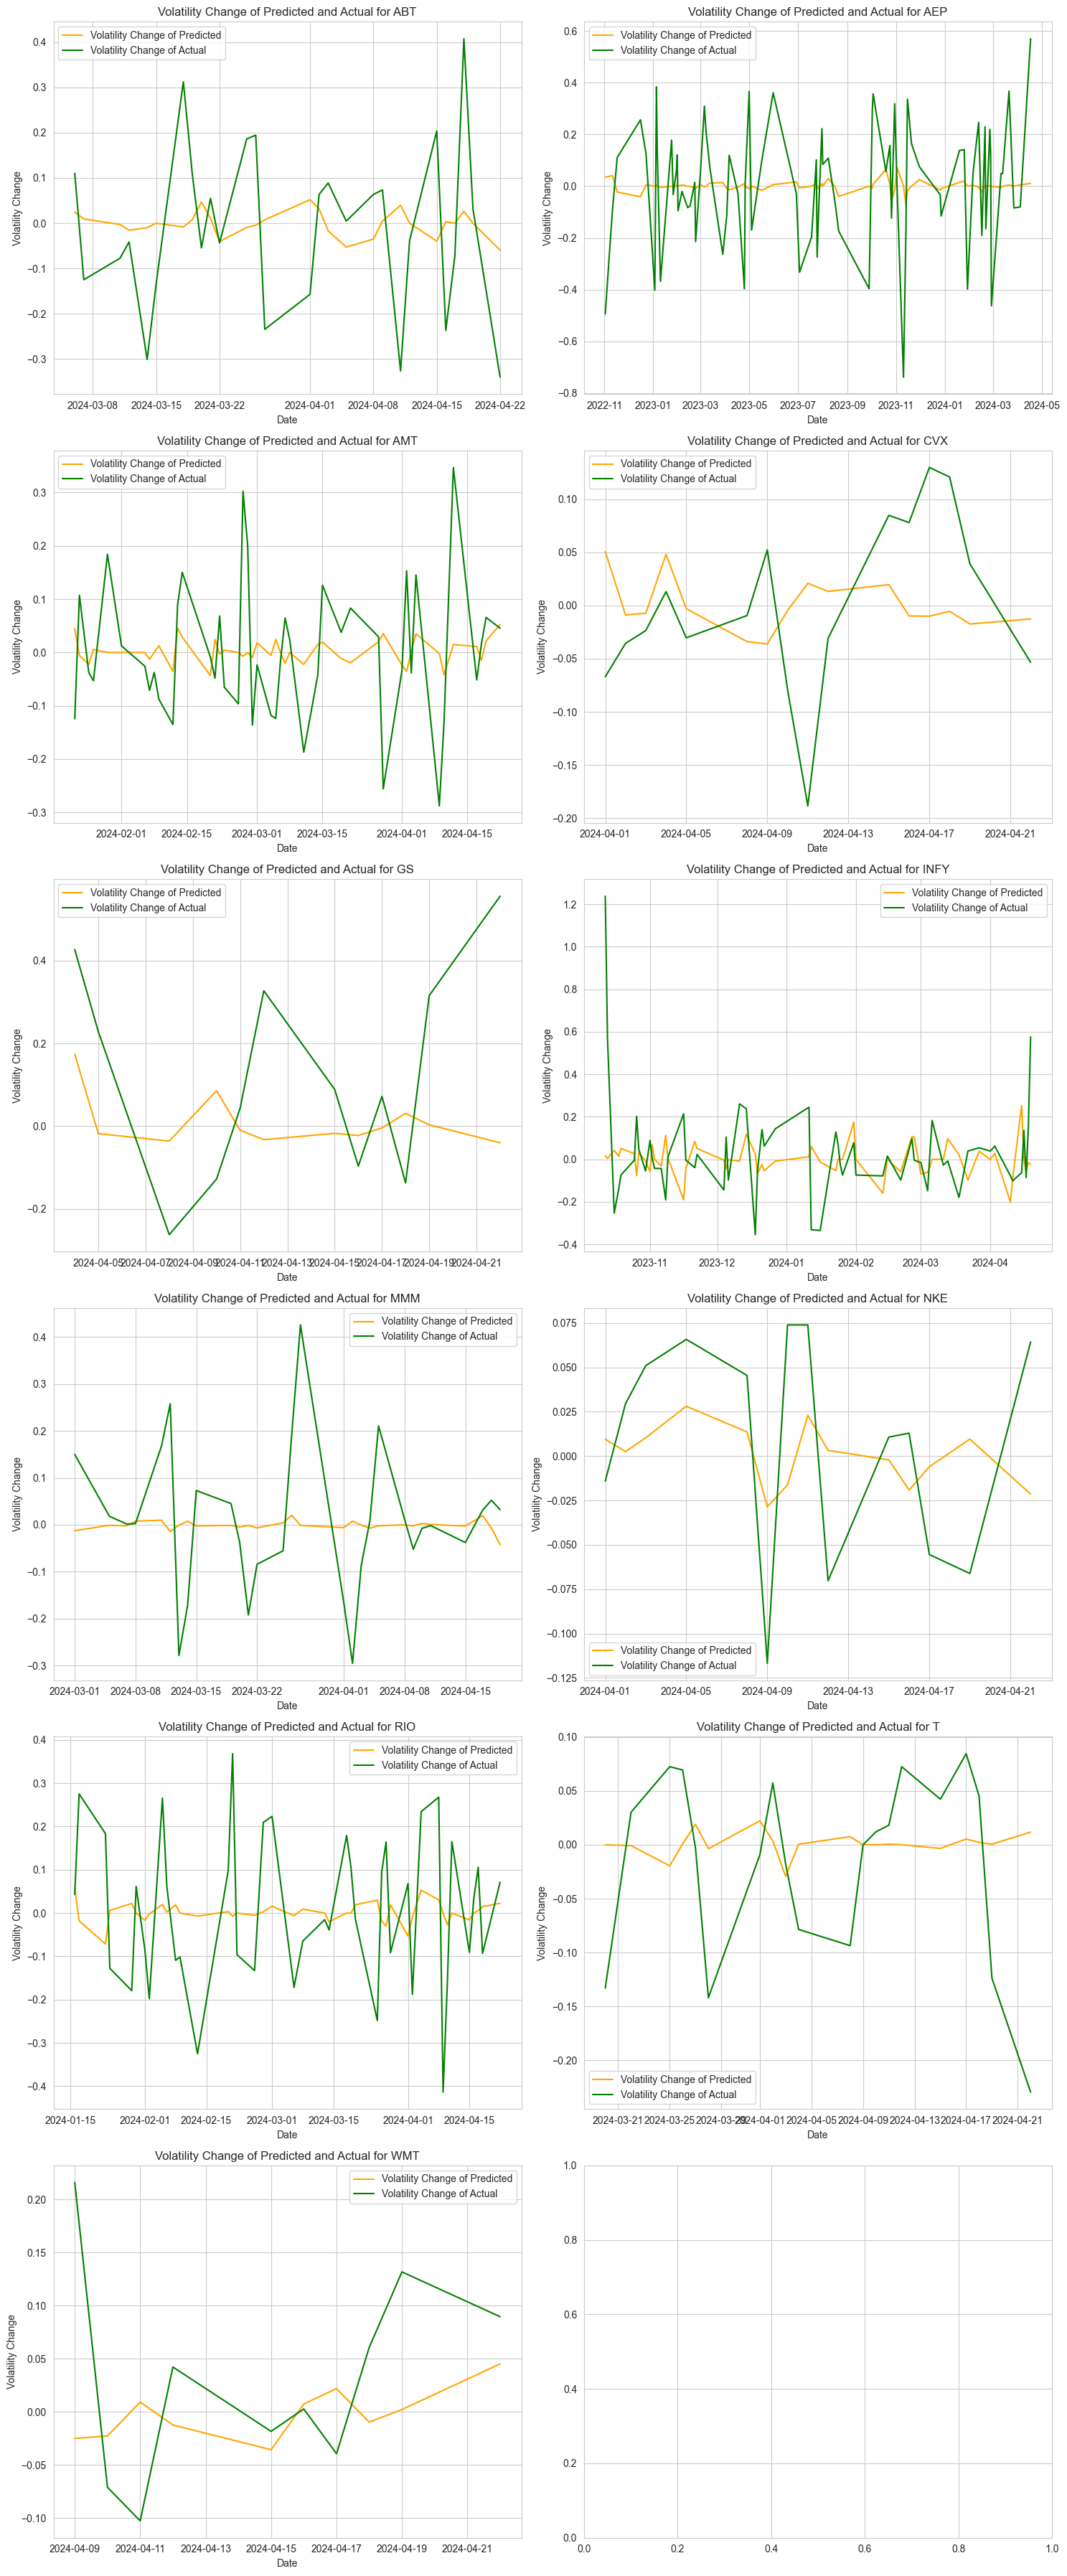

In [50]:
# Plotting actual vs predicted volatility change, derivative of volatility
tickers = result_df['Ticker'].unique()

num_rows = (len(tickers) + 1) // 2
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))
axes = axes.flatten()

for i, (ticker, ax) in enumerate(zip(tickers, axes)):
    ticker_data = result_df[result_df['Ticker'] == ticker]
    
    volatility_change_predicted = np.gradient(ticker_data['Predicted'])
    volatility_change_actual = np.gradient(ticker_data['Actual'])

    ax.plot(ticker_data['Date'], volatility_change_predicted, label='Volatility Change of Predicted', color='orange')
    ax.plot(ticker_data['Date'], volatility_change_actual, label='Volatility Change of Actual', color='green')
    
    ax.set_title(f'Volatility Change of Predicted and Actual for {ticker}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Volatility Change')
    ax.legend()

plt.tight_layout()
plt.show()


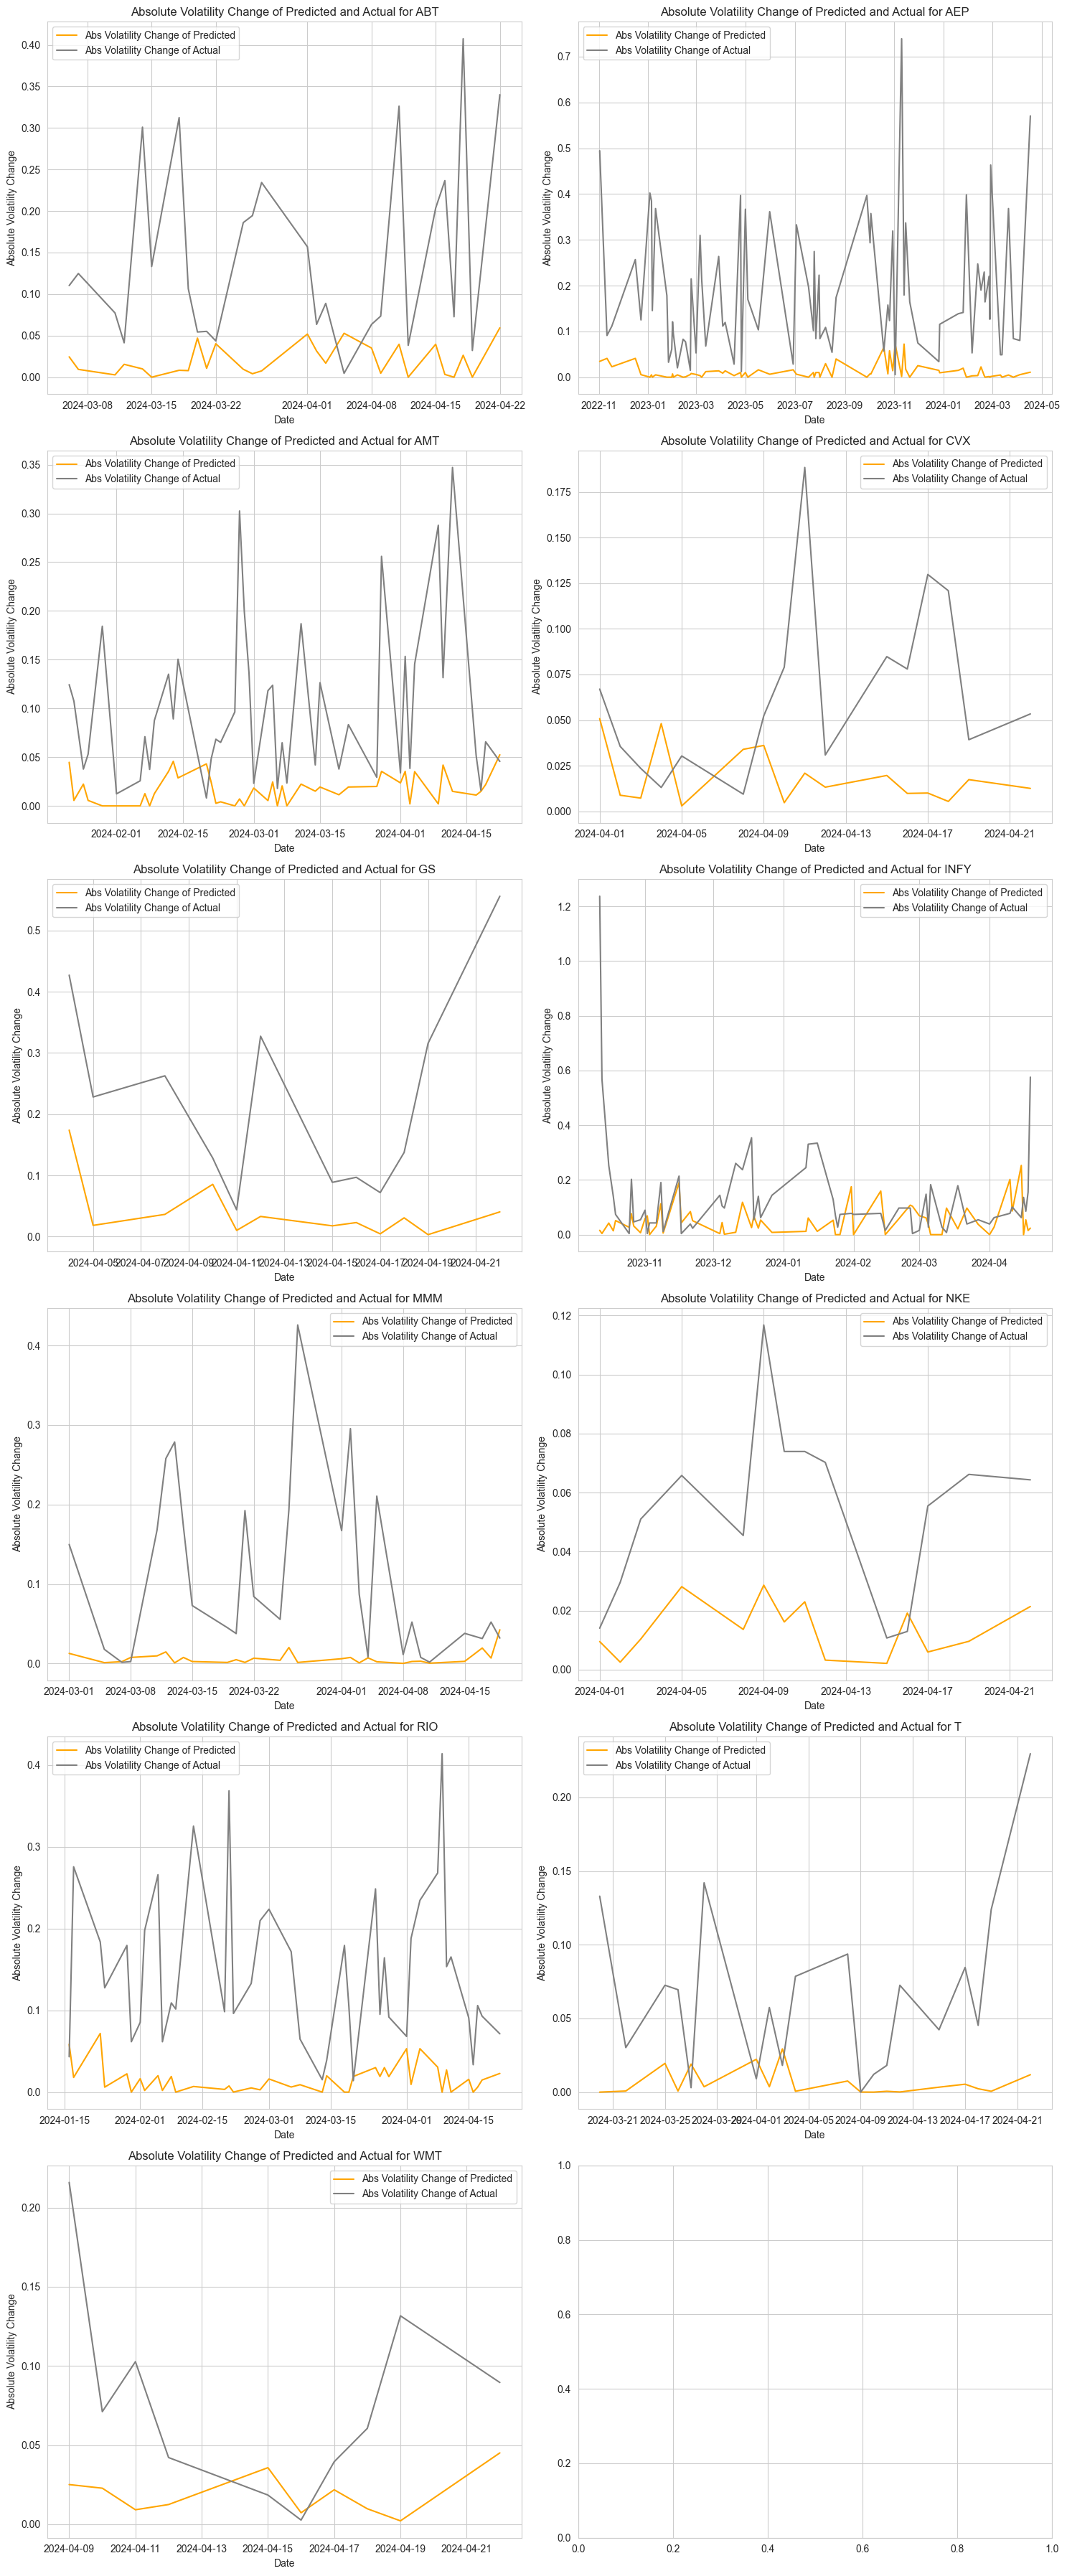

In [51]:
# Ploting the absolute volatility change for actual vs predicted
tickers = result_df['Ticker'].unique()

num_rows = (len(tickers) + 1) // 2
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))
axes = axes.flatten()

# Iterate over each ticker and its corresponding subplot
for i, (ticker, ax) in enumerate(zip(tickers, axes)):
    ticker_data = result_df[result_df['Ticker'] == ticker]
    
    abs_volatility_change_predicted = np.abs(np.gradient(ticker_data['Predicted']))
    abs_volatility_change_actual = np.abs(np.gradient(ticker_data['Actual']))
    
    ax.plot(ticker_data['Date'], abs_volatility_change_predicted, label='Abs Volatility Change of Predicted', color='orange')
    ax.plot(ticker_data['Date'], abs_volatility_change_actual, label='Abs Volatility Change of Actual', color='gray')
    
    ax.set_title(f'Absolute Volatility Change of Predicted and Actual for {ticker}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Absolute Volatility Change')
    ax.legend()

plt.tight_layout()
plt.show()


##### From the plot of absolute volatility change of actual vs predicted, We can observe that the predicted is able to trace the actual volitility change and the peaks are at proper place, but it is not able to predict the magnitude of the peak.